Generate synthetic fundus images containing various defects such as Hard Exudates, Soft Exudates, Hemorrhages and Microaneurysms.

In [14]:
import cv2
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np

In [3]:
base_fundus_img = cv2.imread('imgs/normal_fundus.jpg')
base_fundus_img = cv2.cvtColor(base_fundus_img, cv2.COLOR_BGR2RGB)

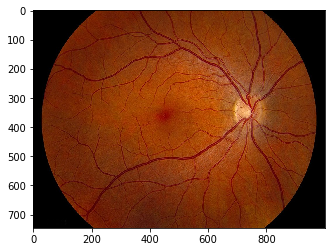

In [5]:
plt.imshow(base_fundus_img)
plt.show()

In [7]:
base_fundus_img.shape

(746, 1000, 3)

In [8]:
def crop_image_from_gray(img, tol=10):
    dims = img.ndim

    if dims == 3:
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif dims == 2:
        gray_image = img

    mask = gray_image > tol

    # find start crop point
    objs = ndimage.find_objects(mask)
    height_offset = objs[0][0].start
    width_offset = objs[0][1].start
    ix = np.ix_(mask.any(1),mask.any(0))

    if dims == 2:
        return img[ix], height_offset, width_offset
    
    check_shape = img[:,:,0][ix].shape[0]
    if (check_shape == 0): # image is too dark so that we crop out everything,
        return img, 0, 0 # return original image

    img1 = img[:,:,0][ix]
    img2 = img[:,:,1][ix]
    img3 = img[:,:,2][ix]
    img = np.stack([img1, img2, img3],axis=-1)

    return img, height_offset, width_offset

In [9]:
def circle_crop(img, sigmaX=50):   
    """
    Create circular crop around image centre    
    """
    img, height_offset, width_offset = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)

    return img, height_offset, width_offset

(746, 1000, 3)
(746, 941, 3)
height_offset 0
width_offset 30



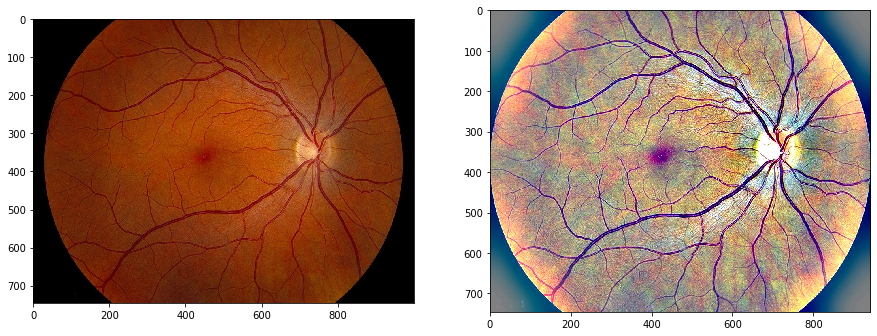

In [18]:
height, width, depth = base_fundus_img.shape
img_t, height_offset, width_offset = circle_crop(base_fundus_img, 50)
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
print(base_fundus_img.shape)
print(img_t.shape)
print("height_offset", height_offset)
print("width_offset", width_offset)
print()

f, axarr = plt.subplots(1,2, figsize=(15,11))
axarr[0].imshow(base_fundus_img)
axarr[1].imshow(img_t)
plt.show()

1. img_t -> transformed image

## Steps - Produce Synthetic Dataset

1. Add HE, SE, Hem, Mic to the base_fundus_image and then produce img_t
2. Apply transforms to img_t to get multiple copies of the base fundus image.
3. Save the masks and the multiple variations of the high quality image.


### Some Mental Notes

base_fundus_image -> apply random defects to generate global retina images with damage.

In [38]:
def flip_image(img, mode='h'):
    """
    Flips the image horizontally or vertically depending on the mode.
    """

    if mode == 'h':
        aug = iaa.Fliplr()
    else:
        aug = iaa.Flipud()
        
    flipped_img = aug(image=img)
    return flipped_img

In [39]:
def plot_two_imgs_side_by_side(img1, img2):
    """
    Horizontally plot two images side by side for better viewing.
    """    
    f, axarr = plt.subplots(1,2, figsize=(15,11))
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()

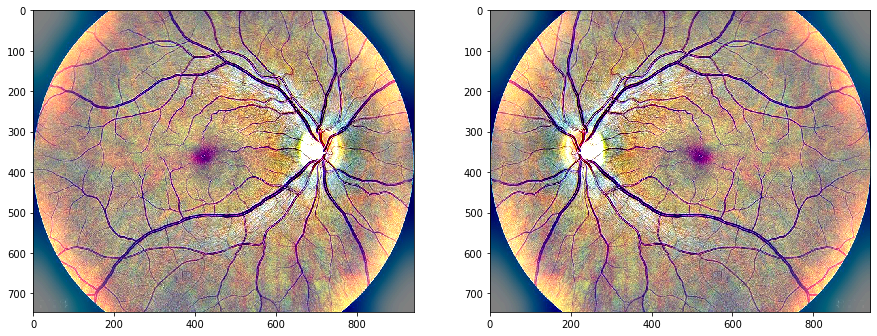

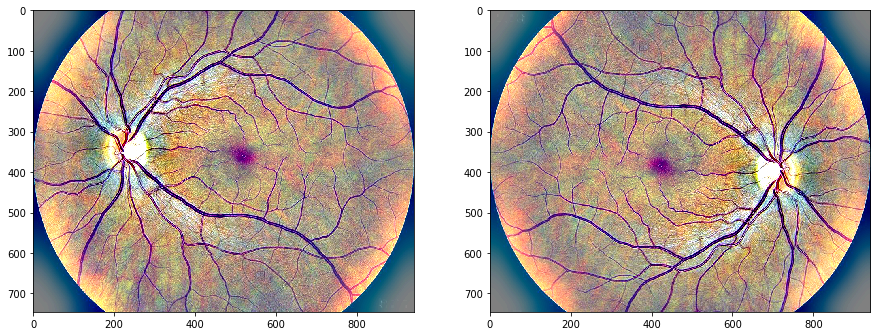

In [43]:
img_t_fliplr = flip_image(img_t)
img_t_flipud = flip_image(img_t, mode='v')
plot_two_imgs_side_by_side(img_t, img_t_fliplr)
plot_two_imgs_side_by_side(img_t_fliplr, img_t_flipud)

In [44]:
def cv2_clipped_zoom(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

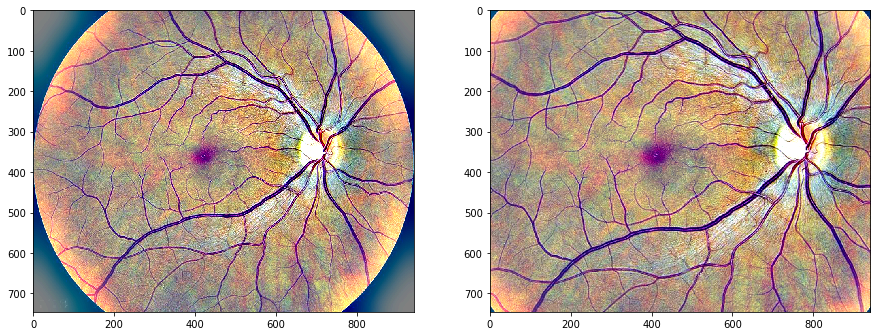

In [47]:
zoom_factors = [1.15, 1.25, 1.35, 1.45, 1.55, ]
zoomed_img = cv2_clipped_zoom(img_t, 1.25)
plot_two_imgs_side_by_side(img_t, zoomed_img)